This is the Project licensed by Dulguun.B. Kek

Энэхүү прожектоор теннис тоглох хөдөлгөөнийг тодорхойлохын тулд гүн сургалт болон LSTM хослуулан ажиллуулах болно.

Prepare Packages

In [61]:
%pip install -r requirements.txt

^C
Note: you may need to restart the kernel to use updated packages.


  Using cached moviepy-2.1.2-py3-none-any.whl.metadata (6.9 kB)
  Using cached pafy-0.5.5-py2.py3-none-any.whl.metadata (10 kB)
  Using cached youtube_dl-2021.12.17-py2.py3-none-any.whl.metadata (1.5 kB)
  Using cached gdown-4.6.3-py3-none-any.whl.metadata (4.4 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached thop-0.1.1.post2209072238-py3-none-any.whl.metadata (2.7 kB)
  Using cached beautifulsoup4-4.13.4-py3-none-any.whl.metadata (3.8 kB)
  Using cached gast-0.4.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached tensorboard-2.12.3-py3-none-any.whl.metadata (1.8 kB)
  Using cached tensorflow_estimator-2.12.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached keras-2.12.0-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached google_auth-2.40.1-py2.py3-none-any.whl.metadata (6.2 kB)
  Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pyasn1

  DEPRECATION: Building 'moviepy' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'moviepy'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\Users\\Dulguun\\.conda\\envs\\tf_clean\\Lib\\site-packages\\tensorflow\\compiler\\tf2tensorrt\\_pywrap_py_utils.pyd'
Consider using the `--user` option or check the permissions.



In [8]:
!nvidia-smi

Tue Jun  3 20:46:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.17                 Driver Version: 561.17         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti   WDDM  |   00000000:2B:00.0  On |                  N/A |
|  0%   48C    P8              9W /  160W |    1217MiB /   8188MiB |      8%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!curl -L -o movenet.tflite "https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0

  0 4646k    0  6050    0     0   2662      0  0:29:47  0:00:02  0:29:45  2662
  2 4646k    2  127k    0     0  42877      0  0:01:50  0:00:03  0:01:47  157k
 52 4646k   52 2448k    0     0   607k      0  0:00:07  0:00:04  0:00:03 1390k
100 4646k  100 4646k    0     0  1077k      0  0:00:04  0:00:04 --:--:-- 2273k


: 

Prepare Datas

In [10]:
import os
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")

Current working directory: c:\Users\Dulguun\Desktop\Workspace\tennis_v0


In [4]:
import cv2
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub
from ultralytics import YOLO
import time
import mediapipe as mp

In [6]:
# Initialize MoveNet
movenet_model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = movenet_model.signatures['serving_default']

# Initialize YOLOv8-pose
yolo_model = YOLO("yolov8n-pose.pt")  # Nano model for speed; use yolov8m-pose.pt for better accuracy

# Initialize Mediapipe
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = None
try:
    pose = mp_pose.Pose(static_image_mode=False, model_complexity=1, enable_segmentation=False, min_detection_confidence=0.5)
    print("MediaPipe Pose initialized successfully.")
except Exception as e:
    print(f"Failed to initialize MediaPipe Pose: {e}")
    raise

# Function to process frame with MediaPipe
def process_frame_mediapipe(frame):
    try:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)
        keypoints = []
        confidence = 0
        if results.pose_landmarks:
            for landmark in results.pose_landmarks.landmark:
                keypoints.extend([landmark.x, landmark.y, landmark.visibility])
            confidence = np.mean([landmark.visibility for landmark in results.pose_landmarks.landmark])
        return np.array(keypoints) if keypoints else np.zeros(33 * 3), confidence, results.pose_landmarks
    except Exception as e:
        print(f"Error in process_frame_mediapipe: {e}")
        raise

# Function to process frame with MoveNet
def process_frame_movenet(frame):
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = tf.image.resize_with_pad(img, 192, 192)
    img = tf.cast(img, dtype=tf.int32)
    img = tf.expand_dims(img, axis=0)
    results = movenet(img)
    keypoints = results['output_0'].numpy()[0, 0, :, :3]  # 17 keypoints (y, x, confidence)
    confidence = np.mean(keypoints[:, 2])
    return keypoints.flatten(), confidence, None  # No landmarks object for drawing

# Function to process frame with YOLOv8
def process_frame_yolo(frame):
    results = yolo_model(frame, verbose=False)[0]
    keypoints = []
    confidence = 0
    if results.keypoints.xy.shape[0] > 0:  # Check if any person detected
        person_keypoints = results.keypoints.xy[0].cpu().numpy()  # (17, 2) for x, y
        person_conf = results.keypoints.conf[0].cpu().numpy()  # (17,) for confidence
        keypoints = []
        for i in range(len(person_keypoints)):
            keypoints.extend([person_keypoints[i, 0] / frame.shape[1],  # Normalize x
                            person_keypoints[i, 1] / frame.shape[0],  # Normalize y
                            person_conf[i]])
        confidence = np.mean(person_conf)
    return np.array(keypoints) if keypoints else np.zeros(17 * 3), confidence, None

# Function to draw keypoints for MoveNet/YOLOv8 (COCO 17-keypoint format)
def draw_keypoints_coco(frame, keypoints, frame_width, frame_height, threshold=0.3):
    connections = [
        (0, 1), (0, 2), (1, 3), (2, 4), (5, 6), (5, 7), (7, 9), (6, 8), (8, 10),
        (5, 11), (6, 12), (11, 12), (11, 13), (13, 15), (12, 14), (14, 16)
    ]
    for i in range(0, len(keypoints), 3):
        x, y, conf = keypoints[i:i+3]
        if conf > threshold:
            cx, cy = int(x * frame_width), int(y * frame_height)
            cv2.circle(frame, (cx, cy), 5, (0, 255, 0), -1)
    for start, end in connections:
        x1, y1, c1 = keypoints[start*3:start*3+3]
        x2, y2, c2 = keypoints[end*3:end*3+3]
        if c1 > threshold and c2 > threshold:
            cv2.line(frame, (int(x1 * frame_width), int(y1 * frame_height)),
                     (int(x2 * frame_width), int(y2 * frame_height)), (0, 0, 255), 2)
    return frame

# Function to process video, extract keypoints, and save video with keypoints
def extract_keypoints(video_path, output_dir, model_type="mediapipe", sequence_length=30, output_video_name="output_with_keypoints.mp4"):
    # Open input video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return [], 0

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Initialize VideoWriter
    os.makedirs(output_dir, exist_ok=True)
    output_video_path = os.path.join(output_dir, output_video_name)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))
    if not out.isOpened():
        print(f"Error: Could not create output video {output_video_path}")
        cap.release()
        return [], 0

    keypoints_sequence = []
    frame_count = 0
    all_sequences = []
    start_time = time.time()

    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Process frame based on model type
            if model_type == "mediapipe":
                keypoints, confidence, landmarks = process_frame_mediapipe(frame)
            elif model_type == "movenet":
                keypoints, confidence, landmarks = process_frame_movenet(frame)
            elif model_type == "yolo":
                keypoints, confidence, landmarks = process_frame_yolo(frame)
            else:
                raise ValueError("Unsupported model_type. Use 'mediapipe', 'movenet', or 'yolo'.")

            if len(keypoints) > 0:
                keypoints_sequence.append(keypoints)

            # Draw keypoints on frame
            if model_type == "mediapipe" and landmarks:
                mp_drawing.draw_landmarks(frame, landmarks, mp_pose.POSE_CONNECTIONS)
            else:
                frame = draw_keypoints_coco(frame, keypoints, frame_width, frame_height)

            # Add text overlays
            cv2.putText(frame, f"Frame: {frame_count}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.putText(frame, f"Confidence: {confidence:.2f}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            # Write frame to output video
            out.write(frame)

            # Visualize
            cv2.imshow(f'{model_type.capitalize()} Pose', frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

            frame_count += 1

            # Create sequences of 30 frames
            if len(keypoints_sequence) == sequence_length:
                all_sequences.append(np.array(keypoints_sequence))
                keypoints_sequence = keypoints_sequence[1:]

    finally:
        # Release resources
        cap.release()
        out.release()
        cv2.destroyAllWindows()
        if model_type == "mediapipe" and pose is not None:
            pose.close()
            print("MediaPipe Pose closed.")

    # Calculate FPS
    elapsed_time = time.time() - start_time
    processing_fps = frame_count / elapsed_time if elapsed_time > 0 else 0

    # Save keypoints sequences
    sequences_path = os.path.join(output_dir, f'keypoints_sequences_{model_type}.npy')
    np.save(sequences_path, np.array(all_sequences))

    print(f"Saved keypoints sequences to {sequences_path}")
    print(f"Saved output video to {output_video_path}")
    print(f"Processing FPS ({model_type}): {processing_fps:.2f}")

    return all_sequences, processing_fps

ValueError: Trying to load a model of incompatible/unknown type. 'C:\Users\Dulguun\AppData\Local\Temp\tfhub_modules\29fb93a7b6cbd61f33bf8c76777682f0a9b06839' contains neither 'saved_model.pb' nor 'saved_model.pbtxt'.

In [9]:
video_name = 'test2.mp4'
video_dir = 'videos'

In [ ]:
# Define video input
if not os.path.exists(video_dir):
    os.makedirs(video_dir)
video_path = os.path.join(video_dir, video_name)
if not os.path.exists(video_path):
    print(f"Error: Video file {video_path} not found.")
    exit(1)

print(f"Processing video: {video_path}")

# Define output directory
output_dir = 'keypoints_data'

# Generate output video names correctly
base_name = os.path.splitext(video_name)[0]

# Process with MediaPipe
mediapipe_sequences, mediapipe_fps = extract_keypoints(
    video_path=video_path,
    output_dir=output_dir,
    model_type="mediapipe",
    output_video_name=f"{base_name}_mediapipe_keypoints.mp4"
)

# Process with MoveNet
movenet_sequences, movenet_fps = extract_keypoints(
    video_path=video_path,
    output_dir=output_dir,
    model_type="movenet",
    output_video_name=f"{base_name}_movenet_keypoints.mp4"
)

# Process with YOLOv8
yolo_sequences, yolo_fps = extract_keypoints(
    video_path=video_path,
    output_dir=output_dir,
    model_type="yolo",
    output_video_name=f"{base_name}_yolo_keypoints.mp4"
)


Processing video: videos\test2.mp4
MediaPipe Pose closed.
Saved keypoints sequences to keypoints_data\keypoints_sequences_mediapipe.npy
Saved output video to keypoints_data\test2_mediapipe_keypoints.mp4
Processing FPS (mediapipe): 34.10
Saved keypoints sequences to keypoints_data\keypoints_sequences_movenet.npy
Saved output video to keypoints_data\test2_movenet_keypoints.mp4
Processing FPS (movenet): 10.31
Saved keypoints sequences to keypoints_data\keypoints_sequences_yolo.npy
Saved output video to keypoints_data\test2_yolo_keypoints.mp4
Processing FPS (yolo): 20.69


In [6]:
# Print comparison
print("\nModel Comparison:")
print(f"MediaPipe FPS: {mediapipe_fps:.2f}")
print(f"MoveNet FPS: {movenet_fps:.2f}")
print(f"YOLOv8 FPS: {yolo_fps:.2f}")


Model Comparison:
MediaPipe FPS: 34.10
MoveNet FPS: 10.31
YOLOv8 FPS: 20.69


In [7]:
mediapipe_keypoints = np.load('keypoints_data/keypoints_sequences_mediapipe.npy')
print(f"MediaPipe keypoints shape: {mediapipe_keypoints.shape}")
print(f"MediaPipe keypoints: {mediapipe_keypoints[5]}")

MediaPipe keypoints shape: (267, 30, 99)
MediaPipe keypoints: [[    0.64115      0.3385     0.99983 ...     0.67858     0.71702     0.91969]
 [    0.63388       0.339     0.99984 ...     0.66791     0.71336      0.9149]
 [    0.63276     0.34212     0.99985 ...      0.6661     0.71499     0.91305]
 ...
 [    0.41108      0.3375     0.99949 ...     0.40396     0.68378     0.92655]
 [    0.40454     0.33683     0.99954 ...     0.39559     0.68477     0.93318]
 [     0.4002     0.33984     0.99958 ...     0.48782     0.57965     0.93763]]


In [7]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def visualize_keypoints(sequence, model_name="mediapipe", video_name=""):
    keypoint_count = sequence.shape[1] // 3
    fig, ax = plt.subplots()
    ax.set_title(f'{model_name} Keypoints - {video_name}')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    scatter = ax.scatter([], [], s=30, c='green')

    def init():
        scatter.set_offsets(np.zeros((keypoint_count, 2)))
        return scatter,

    def update(frame):
        frame = frame.reshape((keypoint_count, 3))
        x = frame[:, 0]
        y = 1 - frame[:, 1]  # invert y-axis (optional depending on your coords)
        scatter.set_offsets(np.c_[x, y])
        return scatter,

    ani = animation.FuncAnimation(fig, update, frames=sequence, init_func=init, blit=True, interval=50)
    plt.close(fig)
    return HTML(ani.to_jshtml())

In [10]:
#Testing the visualization function
mediapipe_keypoints = np.load('keypoints_data/keypoints_sequences_mediapipe.npy')

visualize_keypoints(mediapipe_keypoints[10], "mediapipe", video_name)

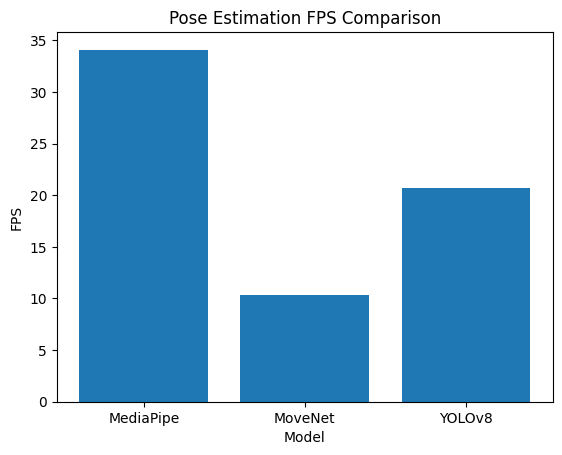

In [10]:
import matplotlib.pyplot as plt
models = ['MediaPipe', 'MoveNet', 'YOLOv8']
fps = [mediapipe_fps, movenet_fps, yolo_fps]
plt.bar(models, fps)
plt.xlabel('Model')
plt.ylabel('FPS')
plt.title('Pose Estimation FPS Comparison')
plt.savefig('fps_comparison.png')

DATASET PROCESSING
python annotator.py videos/MyVideo1.mp4 --output-dir annotations
python extract_keypoints.py

In [11]:
import numpy as np
X = np.load('dataset/X.npy')
y = np.load('dataset/y.npy')
print(X.shape)  # Should be (num_sequences, 30, 99)
print(y.shape)  # Should be (num_sequences,)
print(np.unique(y))  # Should be [0, 1, 2, 3]

# Count samples per class
class_counts = np.bincount(y)
class_names = ['Forehand-GS', 'Backhand-GS', 'Forehand-Volley', 'Backhand-Volley']
for i, count in enumerate(class_counts):
    print(f"Class {i} ({class_names[i]}): {count} samples")

(429, 30, 99)
(429,)
[0 1 2 3]
Class 0 (Forehand-GS): 173 samples
Class 1 (Backhand-GS): 95 samples
Class 2 (Forehand-Volley): 60 samples
Class 3 (Backhand-Volley): 101 samples


In [45]:
visualize_keypoints(X[3], "mediapipe")

In [12]:
# Normalize the data
X = (X - np.mean(X, axis=(1, 2), keepdims=True)) / (np.std(X, axis=(1, 2), keepdims=True) + 1e-8)

In [13]:
# Handle missing keypoints (replace zeros with previous frame)
for i in range(len(X)):
    for t in range(1, X.shape[1]):
        if np.all(X[i, t] == 0):
            X[i, t] = X[i, t-1]

In [14]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, num_classes=4)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (343, 30, 99), y_train shape: (343, 4)
X_test shape: (86, 30, 99), y_test shape: (86, 4)


In [17]:
print("Sample y_train (one-hot):", y_train[:2])
print("X_train min/max:", X_train.min(), X_train.max())

Sample y_train (one-hot): [[          1           0           0           0]
 [          0           0           0           1]]
X_train min/max: -3.1670869677894036 2.539511464052862


In [18]:
print("Sample y_train (one-hot):", y_train[:2])
print("X_train min/max:", X_train.min(), X_train.max())

Sample y_train (one-hot): [[          1           0           0           0]
 [          0           0           0           1]]
X_train min/max: -3.1670869677894036 2.539511464052862


Model

In [194]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LayerNormalization, Dropout

# actions = np.array(['forehand-gs', 'backhand-gs', 'forehand-volley', 'backhand-volley'])
model = Sequential([
    LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 99), dropout=0.2, recurrent_dropout=0.2),
    LayerNormalization(axis=1),
    LSTM(64, return_sequences=False, activation='relu', dropout=0.2, recurrent_dropout=0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')  # 4 classes
])

In [195]:
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 30, 64)         │        41,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_20          │ (None, 30, 64)         │            60 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,744 (303.69 KB)

 Trainable params: 77,744 (303.69 KB)

 Non-trainable params: 0 (0.00 B)

In [196]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [197]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [198]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [199]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.2581 - loss: 1.4496 - val_accuracy: 0.4419 - val_loss: 1.3353
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3535 - loss: 1.3656 - val_accuracy: 0.4302 - val_loss: 1.3134
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3392 - loss: 1.3500 - val_accuracy: 0.4302 - val_loss: 1.2550
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4023 - loss: 1.2889 - val_accuracy: 0.4419 - val_loss: 1.1887
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4728 - loss: 1.1952 - val_accuracy: 0.5349 - val_loss: 1.0529
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4889 - loss: 1.1347 - val_accuracy: 0.5698 - val_loss: 1.0042
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4948 - loss: 1.1457 - val_accuracy: 0.5930 - val_loss: 0.9945
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5523 - loss: 1.0364 - val_accuracy: 0.

In [218]:
# Evaluate model
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Train accuracy: 0.7143
Test accuracy: 0.6977


In [209]:

model.save('tennismodel_final.h5')  # creates a HDF5 file
print("Model saved to tennismodel_final.h5")

Model saved to tennismodel_final.h5


Text(0.5, 1.0, 'Алдагдлын График')

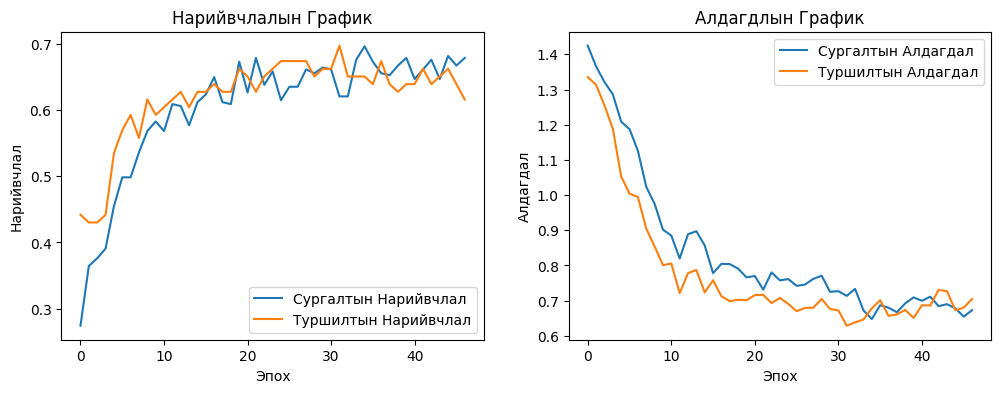

In [210]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Сургалтын Нарийвчлал')
plt.plot(history.history['val_accuracy'], label='Туршилтын Нарийвчлал')
plt.xlabel('Эпох')
plt.ylabel('Нарийвчлал')
plt.legend()
plt.title('Нарийвчлалын График')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Сургалтын Алдагдал')
plt.plot(history.history['val_loss'], label='Туршилтын Алдагдал')
plt.xlabel('Эпох')
plt.ylabel('Алдагдал')
plt.legend()
plt.title('Алдагдлын График')

In [211]:
plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

<Figure size 640x480 with 0 Axes>

In [214]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step
Confusion Matrix:
[[35  0  0  0]
 [ 1  6  0 12]
 [12  0  0  0]
 [ 0  1  0 19]]


In [20]:
import cv2
import mediapipe as mp
import numpy as np
import tensorflow as tf
from pathlib import Path
import os

# Suppress TensorFlow warnings
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Initialize MediaPipe utilities
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Class names
class_names = ['Forehand-GS', 'Backhand-GS', 'Forehand-Volley', 'Backhand-Volley']

def preprocess_sequence(sequence):
    """
    Preprocess a single 30-frame keypoint sequence to match training data.
    """
    sequence = (sequence - np.mean(sequence, axis=(0, 1), keepdims=True)) / (np.std(sequence, axis=(0, 1), keepdims=True) + 1e-8)
    for t in range(1, sequence.shape[0]):
        if np.all(sequence[t] == 0):
            sequence[t] = sequence[t-1]
    return sequence

def extract_keypoints_from_video(video_path, frame_indices=None, sequence_length=30, stride=10):
    """
    Extract 30-frame keypoint sequences from a video.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return None, None, None

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    sequences = []
    sequence_centers = []

    if frame_indices is None:
        frame_indices = range(sequence_length // 2, total_frames - sequence_length // 2, stride)
    else:
        frame_indices = [f for f in frame_indices if sequence_length // 2 <= f < total_frames - sequence_length // 2]

    pose = mp_pose.Pose(static_image_mode=False, model_complexity=1, min_detection_confidence=0.5)
    try:
        for center_frame in frame_indices:
            start_frame = max(0, center_frame - sequence_length // 2)
            end_frame = start_frame + sequence_length
            cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

            keypoints_sequence = []
            frame_count = start_frame

            while frame_count < end_frame:
                ret, frame = cap.read()
                if not ret:
                    break

                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame_rgb = cv2.resize(frame_rgb, (frame_width, frame_height))
                results = pose.process(frame_rgb)

                keypoints = []
                if results.pose_landmarks:
                    for landmark in results.pose_landmarks.landmark:
                        keypoints.extend([landmark.x, landmark.y, landmark.visibility])
                else:
                    keypoints = [0] * 99

                keypoints_sequence.append(keypoints)
                frame_count += 1

            if len(keypoints_sequence) == sequence_length:
                sequences.append(preprocess_sequence(np.array(keypoints_sequence)))
                sequence_centers.append(center_frame)

    finally:
        pose.close()

    cap.release()
    return np.array(sequences), sequence_centers, fps

def test_model_on_video(video_path, model_path, annotation_csv=None, output_video=None, display_duration=1.0):
    """
    Test the model on a video and optionally save output with predictions.
    """
    if not os.path.exists(video_path):
        print(f"Error: Video file {video_path} not found.")
        return

    # Load model
    try:
        model = tf.keras.models.load_model(model_path)
        print(f"Loaded model from {model_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    # Load annotations if provided
    frame_indices = None
    if annotation_csv and os.path.exists(annotation_csv):
        import pandas as pd
        df = pd.read_csv(annotation_csv)
        frame_indices = df['FrameId'].values
        print(f"Loaded {len(frame_indices)} annotated frames from {annotation_csv}")

    # Extract sequences
    sequences, sequence_centers, fps = extract_keypoints_from_video(video_path, frame_indices)
    if sequences is None or len(sequences) == 0:
        print("No valid sequences extracted")
        return

    # Predict
    try:
        predictions = model.predict(sequences, verbose=0)
        predicted_classes = np.argmax(predictions, axis=1)
        confidences = np.max(predictions, axis=1)
    except Exception as e:
        print(f"Error during prediction: {e}")
        return

    # Print predictions
    for i, (center, pred, conf) in enumerate(zip(sequence_centers, predicted_classes, confidences)):
        print(f"Frame {center}: {class_names[pred]} (Confidence: {conf:.2f})")

    # Visualize predictions on video
    if output_video:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Could not open video {video_path} for writing")
            return

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_video, fourcc, fps, (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

        pose = mp_pose.Pose(static_image_mode=False, model_complexity=1, min_detection_confidence=0.5)
        try:
            display_frames = int(fps * display_duration)
            display_ranges = [(max(0, c - display_frames // 2), c + display_frames // 2) for c in sequence_centers]

            frame_idx = 0
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                label = None
                for i, (start, end) in enumerate(display_ranges):
                    if start <= frame_idx <= end:
                        label = f"{class_names[predicted_classes[i]]} ({confidences[i]:.2f})"
                        break

                if label:
                    cv2.putText(frame, label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = pose.process(frame_rgb)
                if results.pose_landmarks:
                    mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

                out.write(frame)
                frame_idx += 1

        finally:
            pose.close()
            cap.release()
            out.release()
            print(f"Output video saved to {output_video}")

In [12]:
import cv2
import mediapipe as mp
import numpy as np
import tensorflow as tf
from pathlib import Path
import os
import pandas as pd

# Suppress TensorFlow warnings
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Initialize MediaPipe utilities
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Class names
class_names = ['forehand', 'backhand', 'neutral', 'serve']

class ShotCounter:
    """Basic shot counter with a shot history for tennis shot classification"""

    MIN_FRAMES_BETWEEN_SHOTS = 30  # Reduced from 60

    BAR_WIDTH = 30
    BAR_HEIGHT = 170
    MARGIN_ABOVE_BAR = 30
    SPACE_BETWEEN_BARS = 55
    TEXT_ORIGIN_X = 50
    BAR_ORIGIN_X = 50

    def __init__(self):
        self.nb_history = 5  # Reduced from 10 to make it more responsive
        self.probs = np.zeros((self.nb_history, len(class_names)))
        self.nb_forehands = 0
        self.nb_backhands = 0
        self.nb_serves = 0
        self.last_shot = "neutral"
        self.frames_since_last_shot = self.MIN_FRAMES_BETWEEN_SHOTS
        self.results = []

    def update(self, probs, frame_id):
        """Update current state with shot probabilities"""

        if len(probs) == 4:
            self.probs = probs
        else:
            self.probs[0:3] = probs

        if (
            probs[0] > 0.98
            and self.frames_since_last_shot > self.MIN_FRAMES_BETWEEN_SHOTS
        ):
            self.nb_backhands += 1
            self.last_shot = "backhand"
            self.frames_since_last_shot = 0
            self.results.append({"FrameID": frame_id, "Shot": self.last_shot})
        elif (
            probs[1] > 0.98
            and self.frames_since_last_shot > self.MIN_FRAMES_BETWEEN_SHOTS
        ):
            self.nb_forehands += 1
            self.last_shot = "forehand"
            self.frames_since_last_shot = 0
            self.results.append({"FrameID": frame_id, "Shot": self.last_shot})
        elif (
            len(probs) > 3
            and probs[3] > 0.98
            and self.frames_since_last_shot > self.MIN_FRAMES_BETWEEN_SHOTS
        ):
            self.nb_serves += 1
            self.last_shot = "serve"
            self.frames_since_last_shot = 0
            self.results.append({"FrameID": frame_id, "Shot": self.last_shot})

        self.frames_since_last_shot += 1

    def display(self, frame):
        """
        Display shot counts on the frame
        Colorize the last shot in green
        """
        y_offset = frame.shape[0] - 120
        cv2.putText(
            frame,
            f"Backhands = {self.nb_backhands}",
            (20, frame.shape[0] - 100),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1,
            color=(0, 255, 0)
            if (self.last_shot == "backhand" and self.frames_since_last_shot < 30)
            else (0, 0, 255),
            thickness=2,
        )
        cv2.putText(
            frame,
            f"Forehands = {self.nb_forehands}",
            (20, frame.shape[0] - 60),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1,
            color=(0, 255, 0)
            if (self.last_shot == "forehand" and self.frames_since_last_shot < 30)
            else (0, 0, 255),
            thickness=2,
        )
        cv2.putText(
            frame,
            f"Serves = {self.nb_serves}",
            (20, frame.shape[0] - 20),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1,
            color=(0, 255, 0)
            if (self.last_shot == "serve" and self.frames_since_last_shot < 30)
            else (0, 0, 255),
            thickness=2,
        )

def draw_probs(frame, probs):
    """
    Draw probability bars for each shot class
    """
    bar_width = ShotCounter.BAR_WIDTH
    bar_height = ShotCounter.BAR_HEIGHT
    margin_above_bar = ShotCounter.MARGIN_ABOVE_BAR
    space_between_bars = ShotCounter.SPACE_BETWEEN_BARS
    text_origin_x = ShotCounter.TEXT_ORIGIN_X
    bar_origin_x = ShotCounter.BAR_ORIGIN_X

    for idx, (prob, name) in enumerate(zip(probs, class_names)):
        x0 = bar_origin_x + idx * space_between_bars
        y0 = frame.shape[0]
        y1 = frame.shape[0] - int(bar_height * prob) - margin_above_bar
        y1 = max(y1, margin_above_bar)
        cv2.rectangle(
            frame,
            (x0, y0 - margin_above_bar),
            (x0 + bar_width, y1),
            (0, 255, 255),
            -1,
        )
        cv2.putText(
            frame,
            name,
            (text_origin_x + idx * space_between_bars, y0 - 5),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.5,
            color=(0, 255, 255),
            thickness=1,
        )

def preprocess_sequence(sequence):
    """
    Preprocess a single 30-frame keypoint sequence to match training data.
    """
    sequence = (sequence - np.mean(sequence, axis=(0, 1), keepdims=True)) / (np.std(sequence, axis=(0, 1), keepdims=True) + 1e-8)
    for t in range(1, sequence.shape[0]):
        if np.all(sequence[t] == 0):
            sequence[t] = sequence[t-1]
    return sequence

def extract_keypoints_from_video(video_path, frame_indices=None, sequence_length=30, stride=10):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return None, None, None

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    sequences = []
    sequence_centers = []

    if frame_indices is None:
        frame_indices = range(sequence_length // 2, total_frames - sequence_length // 2, stride)
    else:
        frame_indices = [f for f in frame_indices if sequence_length // 2 <= f < total_frames - sequence_length // 2]

    pose = mp_pose.Pose(static_image_mode=False, model_complexity=1, min_detection_confidence=0.5)
    try:
        for center_frame in frame_indices:
            start_frame = max(0, center_frame - sequence_length // 2)
            end_frame = start_frame + sequence_length
            cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

            keypoints_sequence = []
            frame_count = start_frame

            while frame_count < end_frame:
                ret, frame = cap.read()
                if not ret:
                    break

                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame_rgb = cv2.resize(frame_rgb, (frame_width, frame_height))
                results = pose.process(frame_rgb)

                keypoints = []
                if results.pose_landmarks:
                    # Select specific landmarks (e.g., indices 11-23 for upper body)
                    selected_landmarks = [11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28, 29]
                    for idx in selected_landmarks:
                        landmark = results.pose_landmarks.landmark[idx]
                        keypoints.extend([landmark.x, landmark.y])  # Only x, y (26 features for 13 landmarks)
                else:
                    keypoints = [0] * 26  # Match the 26 features

                keypoints_sequence.append(keypoints)
                frame_count += 1

            if len(keypoints_sequence) == sequence_length:
                sequences.append(preprocess_sequence(np.array(keypoints_sequence)))
                sequence_centers.append(center_frame)

    finally:
        pose.close()

    cap.release()
    return np.array(sequences), sequence_centers, fps

def test_model_on_video(video_path, model_path, annotation_csv=None, output_video=None, display_duration=1.0):
    """
    Test the model on a video and optionally save output with predictions and shot counts.
    """
    if not os.path.exists(video_path):
        print(f"Error: Video file {video_path} not found.")
        return

    # Load model
    try:
        model = tf.keras.models.load_model(model_path)
        print(f"Loaded model from {model_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    # Initialize shot counter
    shot_counter = ShotCounter()

    # Load annotations if provided
    frame_indices = None
    if annotation_csv and os.path.exists(annotation_csv):
        df = pd.read_csv(annotation_csv)
        frame_indices = df['FrameId'].values
        print(f"Loaded {len(frame_indices)} annotated frames from {annotation_csv}")

    # Extract sequences
    sequences, sequence_centers, fps = extract_keypoints_from_video(video_path, frame_indices)
    if sequences is None or len(sequences) == 0:
        print("No valid sequences extracted")
        return

    # Predict
    try:
        predictions = model.predict(sequences, verbose=0)
        predicted_classes = np.argmax(predictions, axis=1)
        confidences = np.max(predictions, axis=1)
    except Exception as e:
        print(f"Error during prediction: {e}")
        return

    # Print predictions
    for i, (center, pred, conf) in enumerate(zip(sequence_centers, predicted_classes, confidences)):
        print(f"Frame {center}: {class_names[pred]} (Confidence: {conf:.2f})")
        shot_counter.update(predictions[i], center)

    # Visualize predictions on video
    if output_video:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Could not open video {video_path} for writing")
            return

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_video, fourcc, fps, (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

        pose = mp_pose.Pose(static_image_mode=False, model_complexity=1, min_detection_confidence=0.5)
        try:
            display_frames = int(fps * display_duration)
            display_ranges = [(max(0, c - display_frames // 2), c + display_frames // 2) for c in sequence_centers]
            prediction_idx = 0
            frame_idx = 0

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                # Draw pose landmarks
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = pose.process(frame_rgb)
                if results.pose_landmarks:
                    mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

                # Draw shot counts and probabilities
                shot_counter.display(frame)
                if prediction_idx < len(predictions):
                    if frame_idx >= display_ranges[prediction_idx][0] and frame_idx <= display_ranges[prediction_idx][1]:
                        draw_probs(frame, predictions[prediction_idx])
                        # Add prediction text for debugging
                        cv2.putText(
                            frame,
                            f"Frame {sequence_centers[prediction_idx]}: {class_names[np.argmax(predictions[prediction_idx])]} ({np.max(predictions[prediction_idx]):.2f})",
                            (50, 50),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            1,
                            (0, 255, 0),
                            2
                        )
                    if frame_idx > display_ranges[prediction_idx][1]:
                        prediction_idx += 1

                out.write(frame)
                frame_idx += 1

        finally:
            pose.close()
            cap.release()
            out.release()
            print(f"Output video saved to {output_video}")

    # Print shot counter results
    print("\nShot Counter Results:")
    for result in shot_counter.results:
        print(f"Frame {result['FrameID']}: {result['Shot']}")

# if __name__ == "__main__":
#     import argparse
#     parser = argparse.ArgumentParser(description="Test tennis shot classification on a video")
#     parser.add_argument("video", help="Path to input video")
#     parser.add_argument("model", help="Path to trained model")
#     parser.add_argument("--annotation_csv", help="Path to annotation CSV file", default=None)
#     parser.add_argument("--output_video", help="Path to save output video", default=None)
#     parser.add_argument("--display_duration", type=float, help="Duration to display each prediction (seconds)", default=1.0)
#     args = parser.parse_args()

#     test_model_on_video(args.video, args.model, args.annotation_csv, args.output_video, args.display_duration)

In [13]:
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


In [14]:
# Run the test
video_path = 'videos/MyVideo6.mp4'  # Replace with your video path
model_path = 'models/tennismodel_gru.h5'  # Replace with your model path
annotation_csv = None  # Optional, set to None if no annotations
output_video = 'output/output_MyVideo6.mp4'  # Optional, set to None to skip video output
display_duration = 0.5  # Text display duration in seconds

os.makedirs("output", exist_ok=True)

# Verify video exists
if not os.path.exists(video_path):
    print(f"Error: Video file {video_path} not found.")
else:
    test_model_on_video(video_path, model_path, annotation_csv==annotation_csv, output_video, display_duration=1.0)

Loaded model from models/tennismodel_gru.h5


ValueError: Invalid file path or buffer object type: <class 'bool'>

In [202]:
#GRU architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, LayerNormalization, Dropout
# actions = np.array(['forehand-gs', 'backhand-gs', 'forehand-volley', 'backhand-volley'])

model_gru = Sequential([
    GRU(64, return_sequences=True, input_shape=(30, 99), dropout=0.2, recurrent_dropout=0.2),
    LayerNormalization(axis=1),
    GRU(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])
model_gru.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_20 (GRU)                    │ (None, 30, 64)         │        31,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_21          │ (None, 30, 64)         │            60 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_21 (GRU)                    │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,072 (246.38 KB)

 Trainable params: 63,072 (246.38 KB)

 Non-trainable params: 0 (0.00 B)

In [203]:
model_gru.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [204]:
history_gru = model_gru.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.1807 - loss: 1.5554 - val_accuracy: 0.4419 - val_loss: 1.3122
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3898 - loss: 1.2875 - val_accuracy: 0.4767 - val_loss: 1.1495
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5474 - loss: 1.1157 - val_accuracy: 0.5233 - val_loss: 1.0601
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5626 - loss: 0.9916 - val_accuracy: 0.5581 - val_loss: 1.0084
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5583 - loss: 0.9776 - val_accuracy: 0.5581 - val_loss: 0.9701
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5863 - loss: 0.9158 - val_accuracy: 0.5814 - val_loss: 0.9220
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5883 - loss: 0.9370 - val_accuracy: 0.5698 - val_loss: 0.8924
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6363 - loss: 0.8159 - val_accuracy: 0.

In [205]:
# Evaluate model
gru_train_loss, gru_train_acc = model_gru.evaluate(X_train, y_train, verbose=0)
gru_test_loss, gru_test_acc = model_gru.evaluate(X_test, y_test, verbose=0)
print(f"GRU Train accuracy: {gru_train_acc:.4f}")
print(f"GRU Test accuracy: {gru_test_acc:.4f}")

GRU Train accuracy: 0.8047
GRU Test accuracy: 0.7442


In [206]:
model_gru.save('tennismodel_final_gru.h5')  # creates a HDF5 file
print("Model saved to tennismodel_final_gru.h5")

Model saved to tennismodel_final_gru.h5


Text(0.5, 1.0, 'Алдагдлын График')

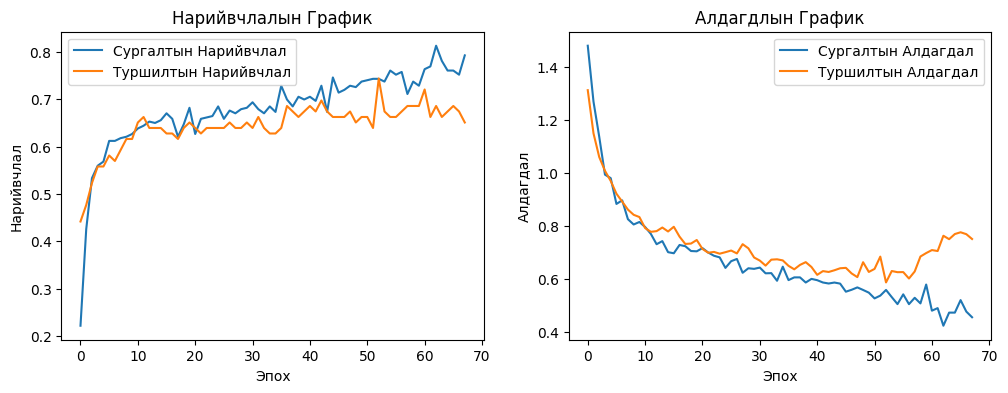

In [212]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_gru.history['accuracy'], label='Сургалтын Нарийвчлал')
plt.plot(history_gru.history['val_accuracy'], label='Туршилтын Нарийвчлал')
plt.xlabel('Эпох')
plt.ylabel('Нарийвчлал')
plt.legend()
plt.title('Нарийвчлалын График')

plt.subplot(1, 2, 2)
plt.plot(history_gru.history['loss'], label='Сургалтын Алдагдал')
plt.plot(history_gru.history['val_loss'], label='Туршилтын Алдагдал')
plt.xlabel('Эпох')
plt.ylabel('Алдагдал')
plt.legend()
plt.title('Алдагдлын График')

In [213]:
plt.tight_layout()
plt.savefig('training_history_gru.png')
plt.show()

<Figure size 640x480 with 0 Axes>

In [217]:
# Run the test
video_path = 'videos/MyVideo6.mp4'  # Replace with your video path
model_path_gru = 'tennismodel_final_gru.h5'
annotation_csv = 'annotations/annotation_MyVideo6.csv'  # Optional, set to None if no annotations
output_video_gru = 'output_MyVideo6_gru.mp4'  # Optional, set to None to skip video output
display_duration = 0.5  # Text display duration in seconds

os.makedirs("output", exist_ok=True)

# Verify video exists
if not os.path.exists(video_path):
    print(f"Error: Video file {video_path} not found.")
else:
    test_model_on_video(video_path, model_path_gru, annotation_csv, output_video_gru, display_duration=1.0)

Loaded model from tennismodel_final_gru.h5
Loaded 3 annotated frames from annotations/annotation_MyVideo6.csv
Frame 46: Forehand-Volley (Confidence: 0.48)
Frame 104: Backhand-GS (Confidence: 0.58)
Frame 174: Forehand-GS (Confidence: 0.97)
Output video saved to output_MyVideo6_gru.mp4


In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.compat.v1)

2025-06-04 01:46:38.205107: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-04 01:46:38.232954: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-04 01:46:38.232987: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-04 01:46:38.234056: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-04 01:46:38.239511: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-04 01:46:38.240405: I tensorflow/core/platform/cpu_feature_guard.cc:1

2.15.0
<module 'tensorflow.compat.v1' from '/home/dgduk/anaconda3/envs/tfjs-convert/lib/python3.10/site-packages/tensorflow/_api/v2/compat/v1/__init__.py'>


In [7]:
import os

print(os.listdir())

['.git', '.gitattributes', '.gitignore', 'Anaconda3-2024.10-1-Linux-x86_64.sh', 'annotations', 'annotator.py', 'dataset', 'dump', 'extract_human_pose.py', 'extract_keypoints.py', 'fps_comparison.png', 'images', 'keypoints_data', 'models', 'model_plot.png', 'movenet.tflite', 'notebook.ipynb', 'output', 'output_MyVideo6.mp4', 'output_video.mp4', 'README.md', 'requirements.txt', 'tennisApp', 'tennismodel_gru.h5', 'test_model_on_video.py', 'track_and_classify_with_rnn.py', 'training_history.png', 'training_history_gru.png', 'utils', 'v1', 'videos', 'yolov8n-pose.pt']


Convert to Tensorflow Lite

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

export_model = Sequential()
export_model.add(GRU(units=24, dropout=0.0, input_shape=(30, 26)))  # Disable GRU dropout
# No standalone Dropout layer
export_model.add(Dense(units=8, activation='relu'))
export_model.add(Dense(units=nb_cat, activation='softmax'))

Below Codes DONT WORKKK

In [ ]:
import tensorflow as tf

# Load your GRU-based Keras model
model = tf.keras.models.load_model('models/tennismodel_gru_legacy.h5')

# Set up the converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable Select TF Ops (allows fallback to TF ops not natively supported in TFLite)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

# Disable experimental lowering of TensorList ops
converter._experimental_lower_tensor_list_ops = False

# Convert the model
tflite_model = converter.convert()

# Save the result
with open("tennis.tflite", "wb") as f:
    f.write(tflite_model)

In [ ]:
import tensorflowjs as tfjs
model = tf.keras.models.load_model('models/tennismodel_gru_legacy.h5')
tfjs.converters.save_keras_model(model, 'tfjs_model')